In [64]:
import torch
import os
import time
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from torch.autograd import grad
from torch.nn import Parameter
cuda = torch.cuda.is_available()
from google.colab import drive
import pickle as pk
from torchsummary import summary

In [3]:
root_path = '/content/drive'
drive.mount(root_path)

Mounted at /content/drive


In [5]:
a = np.array([[1, 2],[3, 4]], dtype=float)
b = torch.FloatTensor([[1, 2],[3, 4]])
c = torch.from_numpy(a)
a == b.numpy()


array([[ True,  True],
       [ True,  True]])

In [6]:
d = torch.ones([2,3,4])
#print(d)
e = d.reshape([-1, 2])
#print(e)
#print(e.shape)

torch.einsum('i, i ->', b.reshape(-1), b.reshape(-1))

torch.einsum('ij, ik -> ik', b, b)

tensor([[ 3.,  6.],
        [21., 28.]])

In [7]:
yhat = torch.Tensor([1, 2, 3])
#yhat.requires_grad = True
# stores instanse with grad = true
yhat = Parameter(yhat)
t = torch.Tensor([0, 2, 3])

def mse(y, t):
  return torch.dot((y-t), (y-t))

def manual_grad(y, t):
  return 2*(y-t)

z = mse(yhat, t)
grad(z, yhat)


(tensor([2., 0., 0.]),)

In [8]:
# NN Architecture
## all lyers that we want to use are in package nn and we can use as many layers as we want
import torch.nn.functional as f
import torch.optim as optim
import torch.nn as nn
from collections import OrderedDict

fc = nn.Linear(in_features=20, out_features=10)

In [9]:
model = nn.Sequential(OrderedDict([('fc1', nn.Linear(in_features=20*28, out_features=1024)),
                                   ('sigmoid', nn.Sigmoid()),
                                   ('fc2', nn.Linear(in_features=1024, out_features=10))]))
model

Sequential(
  (fc1): Linear(in_features=560, out_features=1024, bias=True)
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [10]:
layers = [
          nn.Linear(28*28, 1024),
          nn.Sigmoid(),
          nn.Linear(1024, 10)
]
model2 = nn.Sequential(*layers)
model2

Sequential(
  (0): Linear(in_features=784, out_features=1024, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=1024, out_features=10, bias=True)
)

In [11]:
class FCModel(nn.Module):
  def __init__(self):
    super(FCModel, self).__init__()
    self.body = nn.Sequential(OrderedDict([('fc1', nn.Linear(in_features=28*28, out_features=1024)),
                                   ('sigmoid', nn.Sigmoid()),
                                   ('fc2', nn.Linear(in_features=1024, out_features=10))]))
  def forward(self, x):
    b, c, *_ = x.shape
    x = x.reshape([b, 28*28])
    return self.body(x)

model3 = FCModel()
model3

FCModel(
  (body): Sequential(
    (fc1): Linear(in_features=784, out_features=1024, bias=True)
    (sigmoid): Sigmoid()
    (fc2): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [12]:
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms

In [13]:
train_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [14]:
train_loader = DataLoader(train_data, batch_size=len(train_data))

batch = next(iter(train_loader))
x, y = batch
mean, std = torch.mean(x), torch.std(x)

transform = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean, std)
])

Text(0.5, 1.0, '9')

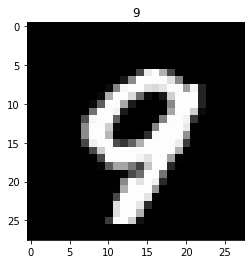

In [32]:
train_data = datasets.MNIST('data', train=True, download=True, transform=transform)

test_data = datasets.MNIST('data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

x, y = next(iter(train_loader))

x.shape

plt.imshow(x[0].reshape([28, 28]), cmap='gray')
plt.title(y[0].item())

In [33]:
a = torch.Tensor([1, 2, 3])
a = a.cuda()
a.device

device(type='cuda', index=0)

In [91]:

def train(model: nn.Module, optimizer: optim.Optimizer, 
          data: Union[DataLoader, Tuple[DataLoader]], max_epoch: int, cuda = torch.cuda.is_available()):
  
  if isinstance(data, DataLoader):
    train_loader = data
  elif isinstance(data, tuple):
    if len(data) == 2:
      train_loader, test_loader = data
      if not isinstance (train_loader, DataLoader):
        raise TypeError(f'Expected DataLoader but got {type(train_loader)}')
      if not isinstance (test_loader, DataLoader):
        raise TypeError(f'Expected DataLoader but got {type(test_loader)}')
    else:
      raise ValueError(f'Expected tuple of lenght 2 but got {len(data)}')
  
  use_test = True
  criterium = nn.CrossEntropyLoss()
  model.train()
  losses = []
  batch_total = len(data[0])

  for epoch in range(max_epoch):
    samples_total = 0
    samples_correct = 0
    samples_correct_test = 0

    for batch_idx, batch in enumerate(train_loader):
      x, y = batch
      if cuda:
        x, y = x.cuda(), y.cuda()
      output = model(x)
      loss = criterium(output, y)
      loss.backward()
      optimizer.step()

      yhat = torch.argmax(output, dim=1)

      samples_total += len(y)
      samples_correct += torch.sum(yhat == y)
      losses.append(loss.item())

      if batch_idx % 50 == 0:
        acc = float(samples_correct) / float(samples_total)
        
        # evaluate on test set each tie´me when we generate output
        if use_test:
          # put model in evaluation mode
          model.eval()

          test_x, test_y = next(iter(test_loader))
          if cuda:
            test_x, test_y = test_x.cuda(), test_y.cuda()
          test_output = model(test_x)
          test_loss = criterium(test_output, test_y)
          test_yhat = torch.argmax(test_output, dim=1)
          samples_correct_test = torch.sum(test_yhat == test_y)
          test_acc = float(samples_correct_test) / float(len(test_y))
          model.train()


          sys.stdout.write(f'\repoch: {epoch} / {max_epoch} Step: {batch_idx}/{batch_total}, Loss: {loss.item():.6f}, Acc: {acc:.2%}, Test Loss: {test_loss:.6f}, Test Acc: {test_acc:.2%},')
        else:
          sys.stdout.write(f'\repoch: {epoch} / {max_epoch} Step: {batch_idx}/{batch_total}, Loss: {loss.item():.6f}, Acc: {acc:.2%}')


  return losses

In [84]:
def validate(model: nn.Module, data: DataLoader, cuda=True):
  criterion = nn.CrossEntropyLoss()
  losses = []
  correct_samples = 0
  total_samples = 0
  for x, y in data:
      if cuda:
        x, y = x.cuda(), y.cuda()
      output = model(x)
      loss = criterion(output, y)
      yhat = torch.argmax(output, dim=1)
      losses.append(loss.item())
      correct_samples += torch.sum(yhat == y)
      total_samples += len(y)

  mean_losses = np.mean(losses)
  acc = float(correct_samples) / float(total_samples)
  print(f'Validation complete! Validation loss: {mean_losses:.6f}, Validation accuracy: {acc:.2%}')

  return mean_losses, acc

In [92]:
from typing import Union, Tuple
start = time.time()
fc_model = FCModel()
fc_model = fc_model.cuda()
fc_optim = optim.Adam(fc_model.parameters(), lr=1e-3)
fc_losses = train(fc_model, fc_optim, (train_loader, test_loader), max_epoch=10)
end = time.time()
print(f'\nTraining took {end - start}s')


epoch: 9 / 10 Step: 900/938, Loss: 2.590835, Acc: 85.63%, Test Loss: 1.219854, Test Acc: 87.50%,
Training took 98.17458319664001s


In [86]:
checkpoint = {'model_state_dict': fc_model.state_dict(),
              'optimizer_state_dict': fc_optim.state_dict(),
              'epoch': 10,
              'losses': fc_losses}
#checkpoint
filename = 'fc_model:10:pth'
checkpoint_path = os.path.join(root_path, 'My Drive', filename)

with open(checkpoint_path, 'wb') as f:
  pk.dump(checkpoint, f)


In [26]:
with open(checkpoint_path, 'rb') as f:
  loaded = pk.load(f)
fc_model_loaded = FCModel()
fc_model.load_state_dict(loaded['model_state_dict'])

<All keys matched successfully>

In [88]:
validate(fc_model_loaded.cuda(), test_loader)

Validation complete! Validation loss: 2.349312, Validation accuracy: 13.81%


(2.3493122629299283, 0.1381)

In [72]:
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    self.head = nn.Linear(128, 10)
    self.body = nn.Sequential(OrderedDict([
                                           ('conv1', nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)),
                                           ('relu1', nn.LeakyReLU()),
                                           ('bn1', nn.BatchNorm2d(16)),
                                           ('pool1', nn.MaxPool2d(kernel_size=2, stride=2)),
                                           ('conv2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)),
                                           ('relu2', nn.LeakyReLU()),
                                           ('bn2', nn.BatchNorm2d(32)),
                                           ('pool2', nn.MaxPool2d(kernel_size=2, stride=2)),
                                           ('conv3', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)),
                                           ('relu3', nn.LeakyReLU()),
                                           ('bn3', nn.BatchNorm2d(64)),
                                           ('pool3', nn.MaxPool2d(kernel_size=2, stride=2)),
                                           ('conv4', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)),
                                           ('relu4', nn.LeakyReLU()),
                                           ('bn4', nn.BatchNorm2d(128)),
                                           ('pool4', nn.MaxPool2d(kernel_size=2, stride=2))
                                           ]))
  
  def forward(self, x):
    y = self.body(x)
    return self.head(y.reshape([-1, 128]))


cnn = CNNModel()
cnn

CNNModel(
  (head): Linear(in_features=128, out_features=10, bias=True)
  (body): Sequential(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): LeakyReLU(negative_slope=0.01)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): LeakyReLU(negative_slope=0.01)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): LeakyReLU(negative_slope=0.01)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [73]:
summary(cnn, input_size=(1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
         LeakyReLU-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
         MaxPool2d-4           [-1, 16, 14, 14]               0
            Conv2d-5           [-1, 32, 14, 14]           4,640
         LeakyReLU-6           [-1, 32, 14, 14]               0
       BatchNorm2d-7           [-1, 32, 14, 14]              64
         MaxPool2d-8             [-1, 32, 7, 7]               0
            Conv2d-9             [-1, 64, 7, 7]          18,496
        LeakyReLU-10             [-1, 64, 7, 7]               0
      BatchNorm2d-11             [-1, 64, 7, 7]             128
        MaxPool2d-12             [-1, 64, 3, 3]               0
           Conv2d-13            [-1, 128, 3, 3]          73,856
        LeakyReLU-14            [-1, 12

In [75]:
cnn = cnn.cuda()
cnn_optim = optim.Adam(cnn.parameters(), lr=1e-3)
cnn_losses = train(cnn, cnn_optim, (train_loader, test_loader), max_epoch=10)

ecpoch: 0 / 10 Step: 900/938, Loss: 0.459869, Acc: 0.90, Test Loss: 0.521984, Test Acc: 0.89,